# A Binary Softmax Classifier in one line of pure Python

A BNN just relies on XNOR and POPCNT.
This can be accomplished in Python as

```bin(a ^ b).count('0')```

## Load the data, reduce resolution to 14x14, and binarize

Text(0.5, 1.0, '5')

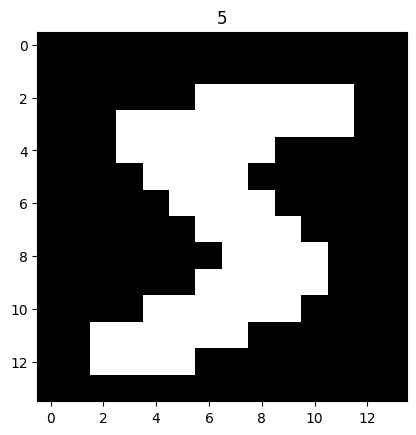

In [19]:
# import MNIST dataset and show an image
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm


from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0,), (1.0,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
validset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)

def binarize_image(image):
  # binarize
  image = torch.where(image > 0., 1., -1.)
  # 2x2 max pooling
  image = image.view(1, 28, 28)
  image = torch.nn.functional.max_pool2d(image, 2, stride=2)
  image = image.view(14, 14)
  return image

# plot the first image in the dataset
image, label = trainset[0]
image = binarize_image(image)
plt.imshow(image, cmap='gray')
plt.title(label)

## Convert bitarrays to integers. (Both the images and the weights must be converted.)

In [20]:
def bits_to_int(bits):
    """ Convert a Tensor of ±1 weights to an integer """
    return sum([2**i if w == 1 else 0 for i, w in enumerate(bits)])
image_number = bits_to_int(image.view(-1))
print('Interger representation of the image: ', image_number, sep='\n\t')

Interger representation of the image: 
	22454421217215396784785283249936507327682043917107200


In [28]:
from bnn.softmax_regression import Net
from bnn.binary_connect_utils import BCSampler
model = Net()
model.load_state_dict(torch.load('models/softmax.pt'))
binary_weights = BCSampler.apply(model.fc1.weight)
weight_numbers = list(bits_to_int(w) for w in binary_weights)
print('Integer representation of the weights: ', *weight_numbers, sep='\n\t')

Integer representation of the weights: 
	69202147822387071132704518855746991949367362255233210354605
	18878814369946987095797706140359643633980551298119608171906
	78540396832536585483368402375151028044931349665181813605288
	59651287096264206496523126758990045730903949349863093764934
	37678846380222160407391793392907136717717661087841581533832
	3171297574277440634209123696293269987358799324618069912093
	94466091066229680046463532016975435255882059900073535301564
	25062623171492492486445059995270854716374161591472388719938
	65926414588134245937835258476719655445011905679206494796871
	50098809060764840098273587919356234368900679506047675839944


## The BNN

We can implement XNOR + POPCNT as
```
bin(image ^ weight_number).count('0')
```

In [29]:
def similarity(image, weight_number):
  return bin(image ^ weight_number).count('0')

# example usage
print('Digits sorted by increasing likelihood: ', 
  sorted(range(10), key = lambda d: similarity(image_number, weight_numbers[d]))
)

Digits sorted by increasing likelihood:  [9, 7, 4, 6, 2, 0, 1, 5, 8, 3]


In [30]:
# evaluation
correct = 0
for i in tqdm(range(len(validset))):
    image, label = validset[i]
    image = binarize_image(image)
    # image.view(-1)
    image = bits_to_int(image.view(-1))
    correct += (label == max(range(10), key = lambda d: similarity(image, weight_numbers[d])))

print('Final accuracy: ', correct / len(validset))


100%|██████████| 10000/10000 [00:07<00:00, 1421.05it/s]

Final accuracy:  0.704


## Conclusion

We can classify an image in 2ms with 70% accuracy. This includes the time required to preprocess (downsample and binarize) the image!

We can do this in pure Python without any external dependencies.

This strategy could make it easy to add a little machine learning to a leighweight library which shouldn't depend on scientific libraries like numpy. All you need to do is include your weight numbers as a list directly in the source code and use the XOR and COUNT operators available in pure Python.